- title: course: (ML Series) Introduction to Machine Learning II
- date: 2020-05-25 12:00
- category: course
- tags: machine learning, python, course
- slug: machine_learn_intro_2
- authors: Julien Hernandez Lallement
- summary: Introduction to Machine Learning II
- illustration: 2020_05_learning_rates2.jpg

## Introduction

This post is the second part of the first [post](https://juls-dotcom.github.io/machine_learn_intro_1.html) on introdution to Machine Learning.

I use several materials to prepare this, such as lectures I attended back in Amsterdam and different books, such as [this one](https://www.amazon.de/Machine-Learning-Applied-Mathematics-Introduction/dp/1916081606) and that [one](https://www.amazon.de/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=bmx_3/260-6773255-8599754?_encoding=UTF8&pd_rd_i=1492032646&pd_rd_r=b1fd8ba5-5d17-4879-816f-a282b1271caa&pd_rd_w=hjnBU&pd_rd_wg=Wg9f2&pf_rd_p=1c6f2f65-ddb5-43f5-b08c-ddcf19e540ae&pf_rd_r=481AWW6FRH1NQGS5T980&psc=1&refRID=481AWW6FRH1NQGS5T980).

Here, I will:
* Introduce the concept of dimensionality & PCA
* Introduce the concept of Maximum Likelihood Estimation
* Introduce the concept of bias/variance & Over/Underfitting

### Dimensionality

When you are dealing with large data sets, one might be struck by the so-called *curse of dimensionality*. What is that scary thing?!

You might think that the more features you have, the best. In some way, indeed, since you increase the amount of information by adding new data features. That is the purpose of feature engineering. 

However, it has quite some down sides as well.

Say you are working with N data points, each having M features. For demonstration purpose, let's keep things simple, and imagine that your numerical values are binary, i.e., your data is only 0 or 1. There will be therefore $2^M$ combinations. 

If your number of data points N is lower than this combination value, you might have each data points spread over each corner of your M-dimensional space. As a direct consequence, the relation between these data points become meaningless because data points become to unique. 

In real world situations, you typically have low number of features, and you might want to identify the features that contribute the most to the variance in the data. To do so you would need to prepare your data before running any ML model on it.

##### Principal Component Analysis

Principal Component Analysis (PCA) allows you to identify movements in your data set. It is a fancier way to throw away / keep features that provide meaningful explanatory power in the problem you are trying to solve.

A PCA will first find the correlation matrix for all the features you would provide. In a second time, it will find the eigenvectors and eigenvalues of that matrix. 

The eigenvector associated with the largest eigenvalue is the first PC. 

The eigenvector associated with the second largest eigenvalue is the second PC.

You can imagine the rest ;)

The size of the eigenvalue determines how much the component contributes to the variance in the data.

As a result, instead of throwing away features that you feel would have high importance, you can use PCA to throw away features with low eigenvalues. Even better, you keep the features that provide a certain threshold of explainability (say 95%).

In the following posts, I will be using PCA ocasionally, so you can have a look at them for demonstration using Python.

### Maximum Likelihood Estimation

Maximum Likelihood Estimation (MLE) is a classic approach to determine parameters in a mathematical model. It works by finding the parameters that maximizes the likelihood of observing the real data. 

Say you go the cinema and you get a ticket stamped with the number "152" on it. What is the probability of getting that ticket?
We need to assume that the ticket numbers are positive, and that the numbering is independent per movie. 

If N is the number of people that are going to the movie, then the probability of getting that ticket is:

$
\frac{1}{N}$ for N > or equal to 152


and the value that maximizes that expression (in other words, the MLE) would be 152 of course.

##### What am I telling you this?

Finding the parameters that best approach the likelihood of the data under the hypothesis is what will bring your model closer to the truth.

The example above is a simple one, but one could look at another, still not complicated one: coss toin.

Say you toss a coin $n$ times and get $i$ heads. What is the probability of cossing heads again at the next toss?

Well, if the tosses are independent, then the probability would be:

$
\frac{n!}{h!(n-h)!} p^h (1-p)^n-h
$

The likelihood function will have a clear maximum, which will be affected by $i$, and applying MLE to this problem boils down to maximizing this expression with respect to $p$. 

Note that when working with probabilities, you will often work with the logarithmic of the likelihood, instead of the raw value. And that will be the terms you will try to maximize (AKA `log likelihood`). The main reason (as far as I know, fact check this!) is that it will allow you to move away from very small number, which will give you less precision eventually.

### Bias and Variance

When you find a relation between an independent $x$ and dependent variable $y$, you can write it in mathematical terms. For example 

$
y = f(x) + \epsilon
$

The term $\epsilon$ refers to the error, which represents some random noise in the data, or systematic noise due to measurement error (often the case in research projects...I should know).

We now come up with an ML model that will be fitted on training data, and minimizing some cost function (think MSE, as in linear regressions). 

What you will often observe is that increasing the number of parameters in your model would reduce the error, sometimes drastically, **on the training data set**. 

Now, of course, you want to predict unseen, new and fresh data points. That data point will also have an error term when piped through the model. But in addition to its own error term, it will receive the error based on the conten of the training set, that is, what the model has seen so far. 

I must say, the math behind this part is still not familiar to me, so I will skip the equations for now. What is important, is that the difference between the expectation and the real data point is modulated by both `Bias` and `Variance` (as well as the error inherent to the data, discussed before as term $\epsilon$).

`Bias` is the divergence is our model compared to our real data, on average. 
`Variance` is a measure of the magnitude of that error

We are stuck with $\epsilon$ (except if we have ways to identify systematic error patterns due to measurements error for example), but we can play around to affect Variance and Bias. A good model would have low bias and low variance. Unfortunately, we often have to find a good balance between these two terms, which refers to the terms of `Overfitting` and `Underfitting`.

#### Underfitting vs. Overfitting

Once you have managed to find the optimum for the cost function, you might have at hand a model that is quite good at predicting data. However, as mentioned before, the residuals typically are calculated on training sets, that is, data that you give the model for it learn the association between the variables. One trap here is to create models that are extremes, that is, they will not generalize well to unseen data because of the way they were trained or programed. <br><br>

This is a very important concept, that will define whether your models will be useful or not 

I insist again: the learned model is only useful if it is able to generalize from the data and allows for prediction.
In other words, a good model shoud
- **only** estimate the **systematic relationships** $f$ in the data
- **ignore** the **random noise** in the data, hence, unsystematic error 

Look at the figure below.<br>

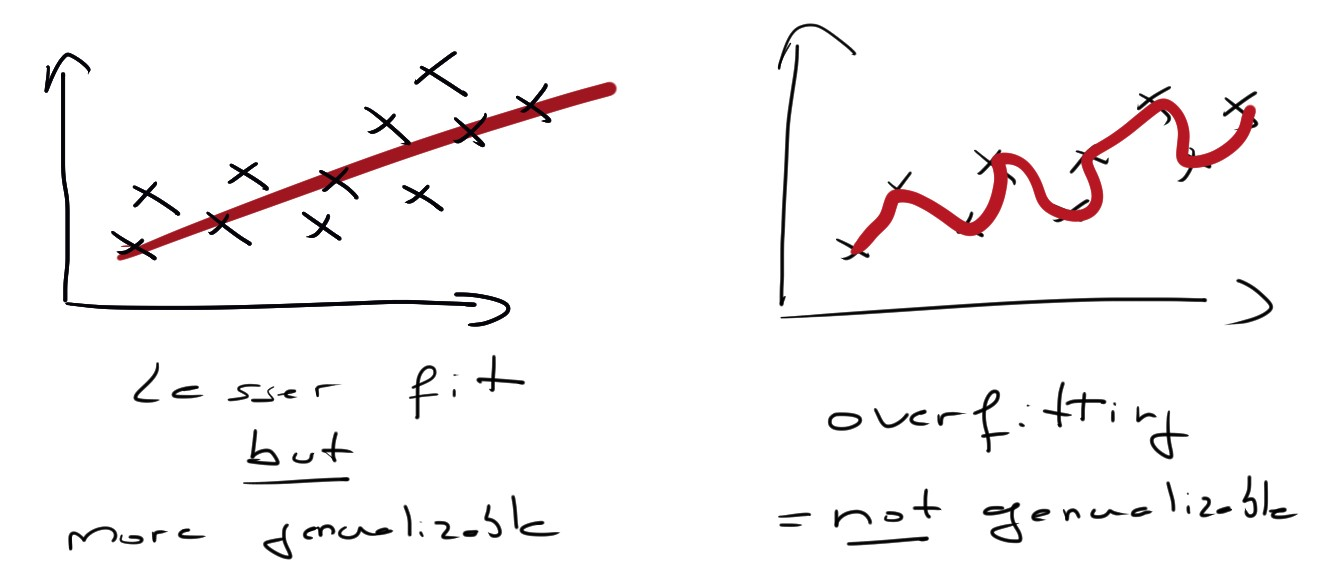

In [3]:
from IPython.display import Image
PATH = "/home/julien/website/content/images/2020_05_ML_Intro_I/"
Image(filename = PATH + "fitting_regimes_crop.jpg", width=800, height=500)

It might be unintuitive for novices in the field, but the model on the right is not a good model to use, because it is too fitted (overfitted) to the train data, and won't be able to capture systematic association between the variables, because too busy capturing the small irrelevant fluctuations present in your current training dataset. The model on the left however might be less accurate on that particular dataset, but will most likely be better at predicting unseen data 

What every engineer and scientist wants is an accurate model that generalizes well on unseen data. The model's performance can be quantified as a value that will be located on a continuum between two extreme cases:
* Underfitting: the model cannot learn the problem. 
* Overfitting:  the model doesn't generalize.

Underfitting means that the model cannot learn the assiciation between variables and target data, maybe because it is missing some features, maybe simply because the model is too simple.

Overfitting means that the model doesn't generalize well, maybe because the model learns to recognize patterns in the data without detecting the intrisic patterns in it, which in turn makes it completely able to detect noise specific to your dataset and unable to detect trends specific to the overall data population from which your sample is taken.

### Final words

That's it for now. In following posts, I will be reporting how I showed and explained futher steps of machine learning project such as model fitting, evaluation and selection. Keep posted!